<a href="https://colab.research.google.com/github/sawa25/ConsultantIntegrator/blob/dev/%D0%94%D0%97_Pro_14_%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_Faiss_%D0%BF%D0%B0%D1%80%D1%81%D0%B8%D0%BD%D0%B3_%D1%81%D0%B0%D0%B9%D1%82%D0%B0_%D0%BD%D0%B0_%D0%B8%D0%BD%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%BD%D0%BE%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Проведите парсинг сайта на любом **иностранном** языке по вашему выбору.
Посмотрите на длины чанков. Выведите **околонулевые** (по длине в токенах) чанки и примите решение о том, нужны ли они в БЗ. Если они не содержат информации, избавьтесь от них.
На основании полученных материалов сделайте нейро-консультанта, который бы отвечал на вопросы по содержимому сайта на **русском** языке. Примените методы экономии токенов (насколько возможно).

In [ ]:
!pip install -q nest_asyncio xmltodict faiss-cpu==1.7.4 langchain==0.1.7 openai==1.12.0 tiktoken==0.6.0 langchain_community==0.0.20 langchain-openai==0.0.6 unstructured

In [ ]:
# fixes a bug with asyncio and jupyter
import nest_asyncio
nest_asyncio.apply()
import xmltodict
from langchain.document_loaders import ReadTheDocsLoader
from langchain.document_loaders.sitemap import SitemapLoader
from langchain.docstore.document import Document
import requests
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import CharacterTextSplitter
from openai import OpenAI

import tiktoken
import matplotlib.pyplot as plt
import getpass
from langchain.vectorstores import FAISS
import re
from IPython.display import display, HTML, clear_output
from IPython.display import display_html
from langchain.document_loaders import UnstructuredFileLoader
# from langchain.document_loaders import NotebookLoader работает глючно - теряет ячейки кода
import hashlib
from tqdm.auto import tqdm
import json



In [ ]:
import os
from google.colab import userdata
import openai


# Получение ключа API от пользователя и установка его как переменной окружения
openai_key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

ваше решение:
### из роботикс получен хмл
https://api.python.langchain.com/robots.txt ->Sitemap: https://api.python.langchain.com/sitemap.xml
### из хмл видно список корневых адресов для разных версий библиотеки лангчейн
### большинство из этих адресов запрещены к доступу на скачивание,
'https://api.python.langchain.com/en/stable/'- доступа нет

'https://api.python.langchain.com/en/latest/' -доступ есть
с ним и будем работать

In [ ]:
# этим способом ничего интересного не загружается
# sitemap_loader.requests_per_second = 2
# # Optional: avoid `[SSL: CERTIFICATE_VERIFY_FAILED]` issue
# sitemap_loader.requests_kwargs = {"verify": False}

loader = SitemapLoader(
    web_path="https://api.python.langchain.com/sitemap.xml",
    filter_urls=["https://api.python.langchain.com/en/latest"],
)
documents = loader.load()
print(documents[0])
print(len(documents))

Fetching pages: 100%|##########| 1/1 [00:00<00:00, 12.86it/s]

page_content='\n\n\n\n\n\n\n\n\n\nLangChain Python API Reference Documentation.\n\n\nYou will be automatically redirected to the new location of this page.\n\n' metadata={'source': 'https://api.python.langchain.com/en/latest/', 'loc': 'https://api.python.langchain.com/en/latest/', 'lastmod': '2024-04-14T16:16:42.729867+00:00', 'changefreq': 'daily', 'priority': '0.9'}
1


In [ ]:
import os
# приготовить хранилище для локальной копии сайта
from google.colab import drive
# для первоначального скачивания сайта в папку docs4colab на моем гугл диске сработал такой способ монтирования
# mountpoint = '/content/drive/docs4colab'
# но повторное монтирование к непустой папке уже нее работает,
# поэтому монтирование изменено
mountpoint = '/content/drive/'
drive.mount(mountpoint, force_remount=True)
basaznany=None
cnt=0
for dirname, _, filenames in os.walk('.'):
    if 'docs4colab' in dirname:
        cnt+=1
        if cnt>5:break #показать несколько папок скачанной ранее структуры файлов
        print(dirname)

Mounted at /content/drive/
./drive/MyDrive/docs4colab
./drive/MyDrive/docs4colab/api.python.langchain.com
./drive/MyDrive/docs4colab/api.python.langchain.com/en
./drive/MyDrive/docs4colab/api.python.langchain.com/en/stable
./drive/MyDrive/docs4colab/api.python.langchain.com/en/latest


In [ ]:
# перваначальное монтирование выглядело так:
# folder_path  = './drive/docs4colab/MyDrive/docs4colab'
# второй раз монтирование выглядит так:
folder_path  = './drive/MyDrive/docs4colab'

# проверка, что можно работать в этой папке docs4colab на моем гугл драйв:
# Открываем файл для записи ('w' означает запись)
file = open(f'{folder_path}/example88.txt', 'w')
# Записываем строку в файл
file.write('Hello, World!\n')
# Закрываем файл
file.close()

In [ ]:
# способ скачивания сайта
# !wget -r -A.html -P folder_path 'https://api.python.langchain.com/en/stable/'

In [ ]:
# долговременная процедура - скачивание целого сайта на локальный диск для дальнейшей работы
# Total wall clock time: 9m 27s
# Downloaded: 4157 files, 330M in 31s (10.6 MB/s)
# запрещенный путь # command = f"wget -r -A.html -P \"{folder_path}\" 'https://api.python.langchain.com/en/stable/'"

# разрешенный
command = f"wget -r -A.html -P \"{folder_path}\" 'https://api.python.langchain.com/en/latest/'"
# Выполняем команду
get_ipython().system(command)

Выходные данные были обрезаны до нескольких последних строк (5000).
Length: unspecified [text/html]
Saving to: ‘./drive/docs4colab/MyDrive/docs4colab/api.python.langchain.com/en/latest/_modules/langchain_community/tools/ainetwork/owner.html’

api.python.langchai     [ <=>                ]  29.66K  --.-KB/s    in 0.007s  

2024-04-14 11:42:57 (4.06 MB/s) - ‘./drive/docs4colab/MyDrive/docs4colab/api.python.langchain.com/en/latest/_modules/langchain_community/tools/ainetwork/owner.html’ saved [30368]

--2024-04-14 11:42:57--  https://api.python.langchain.com/en/latest/_modules/langchain_community/tools/ainetwork/rule.html
Reusing existing connection to api.python.langchain.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./drive/docs4colab/MyDrive/docs4colab/api.python.langchain.com/en/latest/_modules/langchain_community/tools/ainetwork/rule.html’

api.python.langchai     [ <=>                ]  24.49K  --.-KB/s    in 0.006s  

2024-04-14

In [ ]:
# долговременная процедура прочитать все файлы из файловой структуры скачанного сайта
# заняло 27 минут
# прочитать все файлы из локальной папки folder_path
loader = ReadTheDocsLoader(folder_path)
docs = loader.load()
len(docs)

4157

In [ ]:
def num_tokens_from_string(string: str, encoding_name: str="cl100k_base") -> int:
    """Возвращает количество токенов в строке"""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [ ]:
# проверка, как можно сопоставить локальные документы с соответствующими интернет-ресурсами
print(docs[0])
print(docs[0].page_content)
# сейчас в метаданных сохранен полный локальный путь
# можно заменить folder_path на https:// и тогда обращаться к оригинальному документу на сайте
print(folder_path)
print(docs[0].metadata['source'].replace(f'{folder_path}/'[2:], 'https://'))

page_content='' metadata={'source': 'drive/MyDrive/docs4colab/api.python.langchain.com/en/stable/index.html'}

./drive/MyDrive/docs4colab
https://api.python.langchain.com/en/stable/index.html


In [ ]:
# т.к. ответы консультанта будут касаться кода питон, то полезно иметь
# раскраску кода питон с помощбю библиотеки cdnjs
def wrap(code,ind="",startend=True):
    startchunk=f"startchunk[{ind}]"
    html1 = """
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/highlight.js/11.3.1/styles/default.min.css">
    <script src="https://cdnjs.cloudflare.com/ajax/libs/highlight.js/11.3.1/highlight.min.js"></script>
    <script>hljs.highlightAll();</script>
    """
    if startend:
        html2=f"""</br>{startchunk:=^50}</br>{code}{"endchunk":=^50}</br>"""
    else:
        html2=f"""{code}"""
    return html1+html2
# display(HTML(f"<div>{}</div>"))

## изучение базы знаний

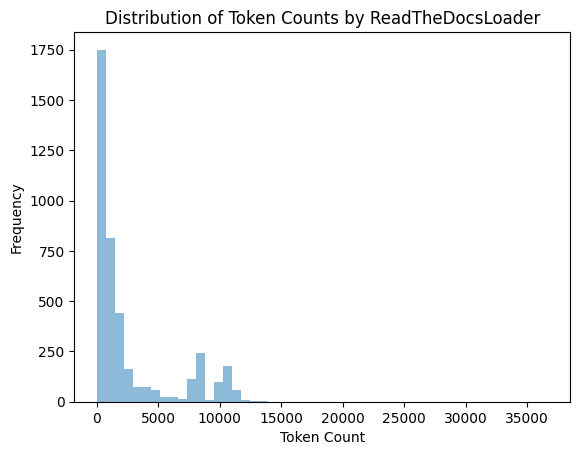

In [ ]:
# Подсчет токенов для каждого фрагмента и построение графика
fragment_token_counts = [num_tokens_from_string(doc.page_content) for doc in docs]
plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
plt.title('Distribution of Token Counts by ReadTheDocsLoader')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# есть очень длинные документы
bigchunks=[]
for i,count in enumerate(fragment_token_counts):
    if count > 15000:
        bigchunks.append(i)
        print(f"{count}[{i}]",end=" ")
len(bigchunks)

32121[29] 20396[834] 21321[2747] 36699[3055] 16993[3083] 18063[3892] 15534[4156] 

7

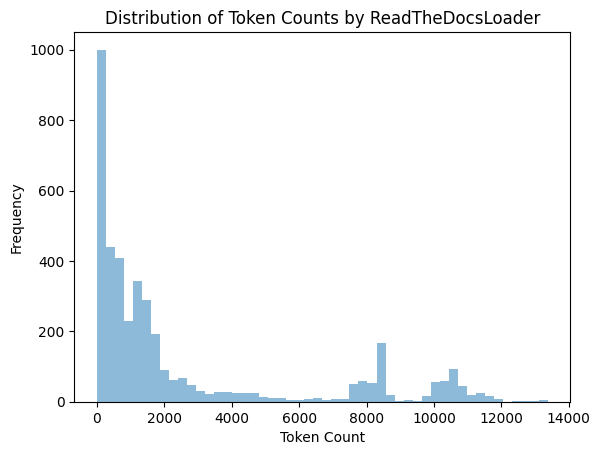

In [ ]:
# распределение размеров чанков с отброшенными наиболее крупными
new_list = [item for item in range(len(fragment_token_counts)) if item not in bigchunks]
plt.hist([fragment_token_counts[i] for i in new_list], bins=50, alpha=0.5, label='Fragments')
plt.title('Distribution of Token Counts by ReadTheDocsLoader')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# есть очень короткие документы
smallchunks=[]
middlechunks=[]
for i,count in enumerate(fragment_token_counts):
    if count < 100:
        smallchunks.append(i)
        print(f"{count}[{i}]",end=" ")
    elif count<200:
        middlechunks.append(i)
print("\n")
for i in middlechunks:
    print(f"{fragment_token_counts[i]}[{i}]",end=" ")


0[0] 0[1] 66[2] 63[5] 11[6] 44[13] 99[14] 11[15] 99[17] 78[18] 11[21] 79[22] 44[24] 66[52] 82[76] 46[92] 79[93] 87[112] 49[119] 49[128] 54[129] 50[133] 39[141] 40[142] 66[146] 46[148] 97[152] 48[159] 49[161] 89[163] 35[164] 67[172] 44[175] 58[176] 50[181] 45[183] 73[189] 53[191] 77[199] 53[203] 54[211] 56[222] 82[224] 87[225] 71[233] 48[236] 45[237] 62[238] 60[247] 93[258] 87[269] 75[271] 83[277] 80[282] 59[287] 79[297] 65[298] 77[301] 56[309] 73[320] 79[321] 50[327] 90[333] 62[336] 49[337] 35[349] 69[350] 65[369] 64[376] 75[385] 83[388] 87[399] 72[400] 72[416] 75[432] 77[433] 74[442] 81[448] 85[462] 76[463] 42[467] 52[474] 84[491] 78[529] 79[552] 58[570] 62[573] 31[586] 73[593] 58[603] 89[610] 74[618] 65[621] 70[631] 70[636] 74[639] 68[648] 74[665] 85[668] 55[674] 55[675] 63[684] 62[696] 54[712] 88[720] 88[725] 72[727] 47[729] 83[732] 44[734] 72[739] 67[740] 62[743] 62[745] 32[746] 60[754] 65[757] 81[761] 88[763] 65[769] 51[775] 60[776] 42[778] 81[779] 63[786] 73[793] 68[797] 86[798] 

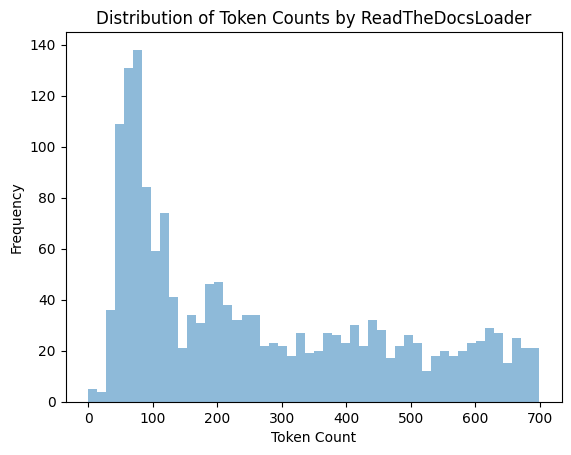

In [ ]:
# распределение размеров небольших чанков
new_list = [item for item in range(len(fragment_token_counts)) if fragment_token_counts[item]<700]
plt.hist([fragment_token_counts[i] for i in new_list], bins=50, alpha=0.5, label='Fragments')
plt.title('Distribution of Token Counts by ReadTheDocsLoader')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

436


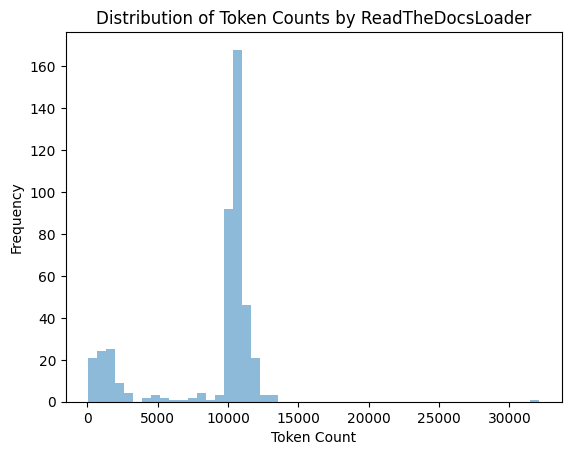

In [ ]:
# распределение размеров чанков с устаревшими методами [Deprecated]
new_list = [item for item in range(len(fragment_token_counts)) if '[Deprecated]' in docs[item].page_content]
print(len(new_list))
plt.hist([fragment_token_counts[i] for i in new_list], bins=50, alpha=0.5, label='Fragments')
plt.title('Distribution of Token Counts by ReadTheDocsLoader')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
docs[2].metadata

{'source': 'drive/MyDrive/docs4colab/api.python.langchain.com/en/latest/together_api_reference.html'}

In [ ]:
# содержимое чанков размера до ~11000токенов с устаревшими методами
new_list = [item for item in range(len(fragment_token_counts)) if '[Deprecated]' in docs[item].page_content]
new_list = [item for item in new_list if 10000<fragment_token_counts[item]<11000]
for i,somechunk in enumerate(new_list[:1]):
    display(HTML(wrap(docs[somechunk].page_content,somechunk)))

In [ ]:
# содержимое чанков размера до 200токенов с устаревшими методами
new_list = [item for item in range(len(fragment_token_counts)) if '[Deprecated]' in docs[item].page_content]
new_list = [item for item in new_list if 0<fragment_token_counts[item]<200]
for i,somechunk in enumerate(new_list):
    display(HTML(wrap(docs[somechunk].page_content,somechunk)))

In [ ]:
# содержимое чанков размера ~100токенов
new_list = [item for item in range(len(fragment_token_counts)) if 90<fragment_token_counts[item]<100]
for i,somechunk in enumerate(new_list[:2]):
    display(HTML(wrap(docs[somechunk].page_content,somechunk)))

In [ ]:
# содержимое чанков размера ~150токенов
new_list = [item for item in range(len(fragment_token_counts)) if 140<fragment_token_counts[item]<150]
for i,somechunk in enumerate(new_list[:2]):
    display(HTML(wrap(docs[somechunk].page_content,somechunk)))

In [ ]:
# содержимое чанков размера 600-700токенов
new_list = [item for item in range(len(fragment_token_counts)) if 600<fragment_token_counts[item]<700]
for i,somechunk in enumerate(new_list[:2]):
    display(HTML(wrap(docs[somechunk].page_content,somechunk)))

In [ ]:
for i,smallchunk in enumerate(smallchunks[:6]):
    display(HTML(wrap(docs[smallchunk].page_content,smallchunk)))

In [ ]:
for i,middlechunk in enumerate(middlechunks[:6]):
    display(HTML(wrap(docs[middlechunk].page_content,middlechunk)))

In [ ]:
for bigchunk in bigchunks:
    display(HTML(wrap(docs[bigchunk].page_content,bigchunk)))

выводы по базе знаний:
1.можно удалить маленькие чанки с текстом [Deprecated] т.к. они содержат по одному устаревшему методу. но таких немного.
2.чанки содержат код питон, функции небольшие, поэтому стоит разделить информацию на довольно маленькие кусочки порядка 700 токенов, чтобы поиском можно было возвращать побольше разнообразных релевантных кусочков, где упоминается тема запроса, - так на вход чатжпт попадет больше информации по использованию интересующего метода библиотеки.

In [ ]:
# функция, добавляющая разделители перед классами,декораторами или перед объявлением функции
# для повышения цельносвязности разбитых на части чанков
def prepchunktosplit(chunktext):
    lines = chunktext.split('\n')
    new_lines = []
    inside_decorator = False
    decorator_added = False  # Флаг для отслеживания, был ли добавлен маркер перед декораторами

    for line in lines:
        if re.match(r'^\s*@', line):
            if not decorator_added:
                new_lines.append('##--##' + line)
                decorator_added = True
            else:
                new_lines.append(line)
            inside_decorator = True
        elif re.match(r'^\s*class\s', line):
            new_lines.append('##--##' + line)
            inside_decorator = False
            decorator_added = False
        elif re.match(r'^\s*def\s', line):
            if not inside_decorator:
                new_lines.append('##--##' + line)
            else:
                new_lines.append(line)
            inside_decorator = False
            decorator_added = False  # Сброс флага после завершения блока декораторов
        else:
            new_lines.append(line)
            if not re.match(r'^\s*$', line):  # Если строка не пуста
                inside_decorator = False
                decorator_added = False  # Сброс флага если строка не продолжает блок декораторов

    return '\n'.join(new_lines)

# Пример использования
text = """
self.table_args = table_args
self.tablename = tablename
self.mapper_args_fn = mapper_args_fn
@classmethod1
@classmethod
def _update_annotations_for_non_mapped_class(
        cls, klass: Type[_O]
    ) -> Mapping....
)
warn_for_non_dc_attrs = collections.defaultdict(list)
def _allow_dataclass_field(
    key: str, originating_class: Type[Any]
) -> bool....
class MyClass:
    def my_method(self):
        pass
"""

print(prepchunktosplit(text))


self.table_args = table_args
self.tablename = tablename
self.mapper_args_fn = mapper_args_fn
##--##@classmethod1
@classmethod
def _update_annotations_for_non_mapped_class(
        cls, klass: Type[_O]
    ) -> Mapping....
)
warn_for_non_dc_attrs = collections.defaultdict(list)
##--##def _allow_dataclass_field(
    key: str, originating_class: Type[Any]
) -> bool....
##--##class MyClass:
##--##    def my_method(self):
        pass



In [ ]:
# еще функция для разметки перед делением
# специальное подготовка чанков, чтобы делить крупные чанки на цельносвязные фрагменты
def prepchunktosplit2(chunktext):
    def replace_header1(match):
        # Возвращаем строку "Return type" и следующую за ней строку с добавлением "###"
        return f"{match.group(1)}{match.group(2)}##--##"


    # Используем регулярное выражение для поиска "Return type" в начале строки и следующей за ней строки,
    # которая является типом возврата
    # Заменяем найденную строку с добавлением "##--##" чтобы делить на чанки в таких местах,
    # чтобы повысить целостность фрагментов кода при делении на чанки

    text = re.sub(r'^(Return type\n)(.*)', replace_header1, chunktext, flags=re.MULTILINE)
    return text
# в основном имеется такая структура текста - описание различных функций
text = """
ххххххх......
Parameters
value (Any) –
Return type
Model
"""
print(prepchunktosplit2(text))


ххххххх......
Parameters
value (Any) –
Return type
Model##--##



In [ ]:
text=prepchunktosplit(docs[4156].page_content)
text=prepchunktosplit2(text)
display(HTML(wrap(text,4156)))

In [ ]:
# проверка, как делится текст
splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=0,
    length_function=lambda x: num_tokens_from_string(x),
    # предпочитать сепаратор сначала класса,потом декоратора, потом корневой функции пото остальные
    separators=["##--##c","##--##@","##--##d","##--##","\n\n", "\n"]
)

for i,chunk in enumerate(splitter.split_text(text)):
    # cleaned_text = re.sub(r'##--##', '', chunk)
    cleaned_text = chunk
    display(HTML(wrap(cleaned_text,f'{i}длина{num_tokens_from_string(cleaned_text)}')))

## почистить лишнее

In [ ]:
print(len(docs))
# удалить маленькие чанки с текстом [Deprecated]
new_list = [item for item in range(len(fragment_token_counts)) if '[Deprecated]' in docs[item].page_content]
new_list = [item for item in new_list if 0<fragment_token_counts[item]<200]
docs0 = [item for i,item in enumerate(docs) if i not in new_list]
print(len(docs0))

4157
4146


In [ ]:
print(docs[0])
print(docs[1])
docs0=docs0[2:] #удалить пустые первые 2 чанка

page_content='' metadata={'source': 'drive/MyDrive/docs4colab/api.python.langchain.com/en/stable/index.html'}
page_content='' metadata={'source': 'drive/MyDrive/docs4colab/api.python.langchain.com/en/latest/index.html'}


In [ ]:
fragment_token_counts0 = [num_tokens_from_string(doc.page_content) for doc in docs0]
# есть очень длинные документы
bigchunks=[]
for i,count in enumerate(fragment_token_counts0):
    if count > 15000:
        bigchunks.append(i)
        print(f"{count}[{i}]",end=" ")
len(bigchunks)

32121[25] 20396[828] 21321[2734] 36699[3042] 16993[3070] 18063[3879] 15534[4143] 

7

# дополнительная обработка текстов, чтобы делить на чанки

In [ ]:
# подготовка базы знаний из всех скачанных документов:
# деление на чанки и формирование списка LangChain Document
# цель расставить сепараторы ##--## так, чтобы делить код на цельносвязные куски(начало класса, конец функции)
m = hashlib.md5()  # this will convert URL into unique ID
splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=0,
    length_function=lambda x: num_tokens_from_string(x),
    # предпочитать сепаратор сначала класса,потом декоратора, потом корневой функции потом остальные
    separators=["##--##c","##--##@","##--##d","##--##","\n\n", "\n"]
)

source_chunks=[]
for fragment in tqdm(docs0, desc="Processing documents"):
    # общая ссылка на документ
    url=fragment.metadata['source'].replace(f'{folder_path}/'[2:], 'https://')
    # convert URL to unique ID
    m.update(url.encode('utf-8'))
    # достаточно для уникального кодирования
    uid = m.hexdigest()[:12]
    # добавление разделителей
    text=prepchunktosplit2(fragment.page_content)
    text=prepchunktosplit(text)
    sublist=[]
    for i,chunk in enumerate(splitter.split_text(text)):
        # удаление разделителей
        cleaned_text = re.sub(r'##--##', '', chunk)
        # сохранить адресацию исходного документа и порядковые номера кусочков
        metadata = {
            'id': f"{uid}",
            'subid':i,
            'total':0,
            'source': url
        }
        readydoc=Document(page_content=cleaned_text, metadata=metadata)
        sublist.append(readydoc)
    # добавить информацию об общем количестве кусочков, представляющих цельный документ
    for chunk in sublist:
        chunk.metadata['total']=len(sublist)
        # display(HTML(wrap(chunk.page_content,chunk.metadata)))
    source_chunks.extend(sublist)


In [ ]:
# всего чанков после деления 4157 отдельных документов
len(source_chunks)

54455

In [ ]:
folder_path

'./drive/MyDrive/docs4colab'

In [ ]:
# построение индекса и сохранение базы на диск
# индексация занимает 10 минут
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()
# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)
# Задаем имя, чтобы идентифицировать сохраненные файлы
index_name = "dbfaiss_from_langchain"
# сохраняем db_from_texts на ваш гугл драйв
db.save_local(folder_path=folder_path, index_name=index_name)

# открыть предварительно сохраненную индексную базу

In [ ]:
# возможность загрузки предварительно сохраненной индексной базы с диска
embeddings = OpenAIEmbeddings()
# Имя, используемое при сохранении файлов
index_name = "dbfaiss_from_langchain"
# Загрузка данных и создание нового экземпляра FAISS
db = FAISS.load_local(
    folder_path=folder_path,
    embeddings=embeddings,
    index_name=index_name
)

In [ ]:
# количество документов в индексной базе
len(db.docstore._dict.items())

54455

In [ ]:
# проверка чанка по id из метаданных
def findindbbyid(id):
    result=None
    for _key, _value in db.docstore._dict.items():
        if _value.metadata['id'] == id:
            # result=_value if not result else result
            # print(_value.page_content,_value.metadata)
            return _value
    print("Element not found")
    return None


In [ ]:
chunk=findindbbyid('2c795f4bdc27')
chunk.metadata['source']

'https://api.python.langchain.com/en/latest/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html'

## дополнить базу другого типа документами - блокнотами ipynb

In [ ]:
# дополнение базы информацией из блокнотов с гитхаба pinecone, где есть примеры использования langchain
# еще в планах добавить https://github.com/langchain-ai/langchain/blob/master/cookbook/README.md (не сделано)
# сохранены в папку на гуглдиске
f"{folder_path}/langchain"

'./drive/MyDrive/docs4colab/langchain'

In [ ]:
# функция для загрузки блокнота ipynb в Document LangChain
# от NotebookLoader пришлось отказаться - он глючит
def loadipynb(fname):
    # fname='/content/drive/MyDrive/docs4colab/langchain/00b-azure-openai-simple.ipynb'
    # Чтение файла ноутбука как JSON
    with open(fname, 'r') as f:
        notebook = json.load(f)
    codecells=[] #ячейки с кодом
    markdowncells=[] #ячейки с текстом
    # Просматриваем код в ячейках
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            codecells.append(''.join(cell['source']))
        elif cell['cell_type'] == 'markdown':
            markdowncells.append(''.join(cell['source']))
    code=''.join(codecells)
    markdown=''.join(markdowncells)
    metadata = {
        'codesize': f"{len(code)}", #в чатжпт предполагается подавать только код, т.е. перед подачей обрезать чанк по размеру кода
        'source': fname
    }
    # для индексации и поиска использовать код и текст из нотбука
    # а для выполнения запроса текст предварительно выкинуть, т.к. чатжпт сам может объяснить код
    readydoc=Document(page_content=''.join([code,markdown]), metadata=metadata)
    return readydoc


In [ ]:
#собрать список лангчейн документов из ипинбов(ipynb)
# здесь в основном нотбуки ipynb, но есть и чистый файл питон py, загружаются разными загрузчиками
root_dir = '/content/drive/MyDrive/docs4colab/langchain'
# root_dir = '/content/drive/MyDrive/docs4colab/langchain/handbook/09-langchain-streaming'

ipynbdocs=[]
# Используем os.walk для обхода всех вложенных папок
for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        fullname=f"{dirpath}/{filename}"
        # Вычисляем длину заполнения на основе длины dirpath
        padding_length = 150-len(fullname)
        if padding_length<0:
            print(padding_length)
            padding_length=0
        # Используем динамическое форматирование внутри f-строки
        pad_string = ('{:=^' + str(padding_length) + '}').format('')
        print(f"{fullname}{pad_string}",end="\n")
        if filename.endswith(".ipynb"):
            ipynbdocs.append(loadipynb(fullname))
        else: #файлы py
            loader = UnstructuredFileLoader(fullname)
            lo = loader.load()
            lo[0].metadata['codesize']=len(lo[0].page_content)
            ipynbdocs.extend(lo)
print(f"всего загружено файлов примеров лангчейн: {len(ipynbdocs)}")


/content/drive/MyDrive/docs4colab/langchain/00b-azure-openai-simple.ipynb=============================================================================
/content/drive/MyDrive/docs4colab/langchain/00-azure-openai-retrieval.ipynb===========================================================================
/content/drive/MyDrive/docs4colab/langchain/rag-chatbot.ipynb=========================================================================================
/content/drive/MyDrive/docs4colab/langchain/v1/claude-3-agent.ipynb===================================================================================
/content/drive/MyDrive/docs4colab/langchain/v1/xml-agents.ipynb=======================================================================================
/content/drive/MyDrive/docs4colab/langchain/handbook/03a-token-counter.ipynb==========================================================================
/content/drive/MyDrive/docs4colab/langchain/handbook/06-langchain-agents.ipynb================

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


всего загружено файлов примеров лангчейн: 21


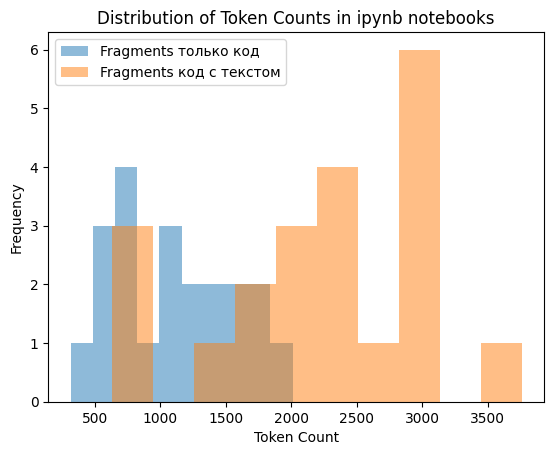

In [ ]:
# Подсчет токенов для каждого фрагмента-документа ipynb и построение графика
# предварительно ipynb были реструктурированы, что сначала идет код, потом весь текст,
# текст поможет поиску по запросу пользователя в индексной базе, а для чатажпт текст предположительно не нужен
# и в запрос подаваться не будет.
# если подавать чатужпт только код, то размер в токенах не более 2000
fragment_token_counts_f = [num_tokens_from_string(doc.page_content) for doc in ipynbdocs]
fragment_token_counts_с = [num_tokens_from_string(doc.page_content[:int(doc.metadata['codesize'])]) for doc in ipynbdocs]

plt.hist(fragment_token_counts_с, bins=10, alpha=0.5, label='Fragments только код')
plt.hist(fragment_token_counts_f, bins=10, alpha=0.5, label='Fragments код с текстом')
plt.title('Distribution of Token Counts in ipynb notebooks')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.legend() # Добавление легенды
plt.show()

#альтернативный вариант загрузки нобуков с маркированием маркдаун ячеек как комментарии внутри кода

In [ ]:
# функция для загрузки блокнота ipynb в Document LangChain
# от NotebookLoader пришлось отказаться - он глючит
def loadipynb(fname):
    # fname='/content/drive/MyDrive/docs4colab/langchain/00b-azure-openai-simple.ipynb'
    # Чтение файла ноутбука как JSON
    with open(fname, 'r') as f:
        notebook = json.load(f)
    codecells=[] #ячейки с кодом
    markdowncells=[] #ячейки с текстом
    # Просматриваем код в ячейках
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            codecells.append(''.join(cell['source']))
        elif cell['cell_type'] == 'markdown':
            # Добавление "# " в начало каждой строки, чтобы эта строка вписцывалась в код, как комментарий
            for line0 in cell['source']:
                modified_text = "\n".join("# " + line2 for line1 in line0.splitlines() if (line2 := line1.strip()) and len(line2) > 1)
                codecells.append(''.join(modified_text))
    code='\n'.join(codecells)
    metadata = {
        'codesize': f"{len(code)}", #в чатжпт предполагается подавать код с комментариями, взятыми из маркдаун ячеек нотбука
        'source': fname
    }
    # для индексации и поиска использовать код и текст из нотбука
    readydoc=Document(page_content=code, metadata=metadata)
    return readydoc

#собрать список лангчейн документов из ипинбов(ipynb)
# здесь в основном нотбуки ipynb, но есть и чистый файл питон py, загружаются разными загрузчиками
root_dir = '/content/drive/MyDrive/docs4colab/langchain'

ipynbdocs=[]
# Используем os.walk для обхода всех вложенных папок
for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        fullname=f"{dirpath}/{filename}"
        # Вычисляем длину заполнения на основе длины dirpath
        padding_length = 150-len(fullname)
        if padding_length<0:
            print(padding_length)
            padding_length=0
        # Используем динамическое форматирование внутри f-строки
        pad_string = ('{:=^' + str(padding_length) + '}').format('')
        print(f"{fullname}{pad_string}",end="\n")
        if filename.endswith(".ipynb"):
            ipynbdocs.append(loadipynb(fullname))
        else: #файлы py
            loader = UnstructuredFileLoader(fullname)
            lo = loader.load()
            lo[0].metadata['codesize']=len(lo[0].page_content)
            ipynbdocs.extend(lo)
print(f"всего загружено файлов примеров лангчейн: {len(ipynbdocs)}")

/content/drive/MyDrive/docs4colab/langchain/00b-azure-openai-simple.ipynb=============================================================================
/content/drive/MyDrive/docs4colab/langchain/00-azure-openai-retrieval.ipynb===========================================================================
/content/drive/MyDrive/docs4colab/langchain/rag-chatbot.ipynb=========================================================================================
/content/drive/MyDrive/docs4colab/langchain/v1/claude-3-agent.ipynb===================================================================================
/content/drive/MyDrive/docs4colab/langchain/v1/xml-agents.ipynb=======================================================================================
/content/drive/MyDrive/docs4colab/langchain/handbook/03a-token-counter.ipynb==========================================================================
/content/drive/MyDrive/docs4colab/langchain/handbook/06-langchain-agents.ipynb================

# ^ конец альтернативного варианта

In [ ]:
# приготовить индексную базу для example-нотбуков и сохранить
# db.add_documents(documents)
embeddings = OpenAIEmbeddings()
dbipynb = FAISS.from_documents(ipynbdocs, embeddings)
index_name = "dbfaiss_from_langchain2"
dbipynb.save_local(folder_path=folder_path, index_name=index_name)

In [ ]:
folder_path

'./drive/MyDrive/docs4colab'

In [ ]:
# считать вторую базу
# на данный момент используется альтернативный вариант
index_name = "dbfaiss_from_langchain2"
dbipynb = FAISS.load_local(
    folder_path=folder_path,
    embeddings=embeddings,
    index_name=index_name
)

In [ ]:
for _key, _value in dbipynb.docstore._dict.items():
    print(f"{_key} {(_value)}")
    break

9c980cef-2f63-431b-8d0d-567c99deaf6b page_content='# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/00b-azure-openai-simple.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/00b-azure-openai-simple.ipynb)\n\n# #### [LangChain Handbook](https://pinecone.io/learn/langchain)\n\n# # Using Azure\'s OpenAI with LangChain\n!pip install -qU \\\n    langchain==0.0.227 \\\n    openai==0.27.8\n# ## Initializing Azure OpenAI\n# To use OpenAI\'s service via Azure we first need to setup the service in Azure via **Azure OpenAI Studio**. In here we need to create a deployment using `gpt-4`.\n\n# Once we\'ve done this we need to set a few environment variables (all found in **Azure OpenAI Studio**) like so:\nimport os\n\no

# translate (перевод запроса на оригинал базы знаний)

In [ ]:
# переводчик - используется для перевода русскоязычного запроса на английский язык, для возможности поиска в эмбедингах
# сформированных на англоязычной базе знаний
def translate_questions(zapros):
    global client
    """
    Функция возвращает английский текст запроса.
    """
    messages = [
        {"role": "system", "content": """
        Ты - русско-английский переводчик. Твоя задача - переводить русскоязычные запросы,
        связанные с темой программирования на языке python, на технический английский язык,
        приближенный к языку написания технической документации библиотек python.
        запрос, требующий перевода delimited by triple quotes \"\"\".
        В качестве ответа возвращай только перевод без рассуждений, без разглагольствований и без лишней информации.
        """},
        {"role": "user", "content": f"""
        \"\"\"{zapros}\"\"\"
        """}
    ]

    completion = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=messages,
        temperature=0,
    )

    # вернуть ответ и потраченные токены
    return completion.choices[0].message.content,completion.__dict__['usage'].__dict__['total_tokens']

In [ ]:
translate_questions("как использовать функцию загрузки документа")

('"How to use the document loading function"', 211)

In [ ]:
# суммаризатор не используется
# def summarize_questions(dialog):
#     """
#     Функция возвращает саммаризированный текст диалога.
#     """
#     messages = [
#         {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - суммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в суммаризированном диалоге"},
#         {"role": "user", "content": "Суммаризируй следующий диалог консультанта и пользователя, тебе запрещено удалять из суммаризации имя пользователя: " + " ".join(dialog)}
#     ]

#     completion = client.chat.completions.create(
#         model="gpt-3.5-turbo-1106",     # используем gpt4 для более точной саммаризации
#         messages=messages,
#         temperature=0,          # Используем более низкую температуру для более определенной суммаризации
#     )

#     # вернуть ответ и потраченные токены
#     return completion.choices[0].message.content,completion.__dict__['usage'].__dict__['total_tokens']

# answer_index

In [ ]:
client = OpenAI()
relevan=0.7 #чем меньше, тем лучше, но дать большую свободу
porogmax=4000 #задать предел токенов(суммарно для системного сообщения и фрагмента базы знаний), за который не выходить для любых запросов

# блок, отвечающий за выбор информации из базы
def extract_json(text):
    # Находим содержимое строки между ```json и ```
    match = re.search(r'```json\n(.*?)```', text, re.DOTALL)
    if match:
        json_str = match.group(1)
        # Удаляем пробелы в начале и конце строки
        json_str = json_str.strip()
        # Выводим содержимое строки
        return json_str
    else:
        return "Content between ```json and ``` not found in the text."
# получение id документа из индексной базы для дальнейшего извлечения из него url
def remove_after_dash(id_list):
    return [id.split('-')[0] for id in id_list]

def answer_index(system,dbdocs,dbexample, search_query,  verbose=0):
    global relevan
    global client
    global porogmax
    num_tokens=0
    porog=porogmax # этот порог соблюдается для всех чанков, кроме чанков из списка specchanks, которым разрешено попасть в запрос несмотря на превышение порога
    messages = [
        {"role": "system", "content": system},
    ]
    #вычесть количество токенов на системную роль,запрос [, пример запроса и ответ ассистента ]
    for mess in messages:
        porog-=num_tokens_from_string(mess['content'])
    porog-=num_tokens_from_string(search_query)

    frags=[]
    scor=[]

    docsipynb = dbexample.similarity_search_with_score(search_query, k=1)
    for i, doc in enumerate(docsipynb):
        page_content=doc[0].page_content[:int(doc[0].metadata['codesize'])] #взять для запроса только код
        nexttopic=f'FRAG№\n{page_content}~~~{doc[0].metadata["source"]}~~~'
        # print(f'{doc[1]:.4f}//{num_tokens_from_string(doc[0].page_content)}{nexttopic}')
        frags.append(nexttopic)
        scor.append(f"{doc[1]:.4f}")
        porog-=num_tokens_from_string(nexttopic)
        break #из нотбуков использовать самый первый

    # Поиск релевантных отрезков из базы знаний по вопросу пользователя
    docs = dbdocs.similarity_search_with_score(search_query, k=20)
    # вычислить, сколько из найденных фрагментов в базе данных можно вставить в запрос
    for i, doc in enumerate(docs):
        nexttopic=f'FRAG№\n{doc[0].page_content}~~~{doc[0].metadata["id"]}-{doc[0].metadata["subid"]}~~~'
        # print(f'{doc[1]:.4f} {porog-num_tokens_from_string(nexttopic, "cl100k_base")}')
        if doc[1]<=relevan:
            # если есть еще резерв токенов, то добавить чанк в запрос
            if porog-num_tokens_from_string(nexttopic)>0:
                frags.append(nexttopic)
                porog-=num_tokens_from_string(nexttopic)
                scor.append(f"{doc[1]:.4f}") #вывести потом все найденные скоры
            else:
                #очередной чанк превысит порог используемых токенов, больше не добавлять
                break

    # message_content = re.sub(r'\n{2}', ' ', '\n '.join(frags))
    message_content = '\n'.join(frags)
    if verbose: print(f'{"message_content":=^50}\n', message_content)
    if verbose: print(f'{"message_content":-^50}\n')
    # return "",porogmax-porog

    messages.append({"role": "user", "content": f"\"\"\"{message_content}\"\"\"\n```{search_query}```"})


    completion = client.chat.completions.create(
        model="gpt-3.5-turbo-0125", #gpt-3.5-turbo-1106
        # response_format={ "type": "json_object" },
        messages=messages,
        temperature=0
    )
    totaltokens=completion.__dict__['usage'].__dict__['total_tokens']
    json_answer = completion.choices[0].message.content
    try:
        # загрузить json объект из ответа
        # Попытка преобразовать извлеченный JSON в объект Python
        json_obj = json.loads(extract_json(json_answer))
        # Если преобразование прошло успешно, вы можете продолжить работу с json_obj
    except json.JSONDecodeError as e:
        # Обработка исключения, возникающего при некорректном JSON
        return f"<div>повторите еще раз этот же вопрос</br>т.к. из-за сбоя модели консультант вернул некорректную структуру:</br>{json_answer}</div>",totaltokens

    # всего два ключа формируются по заданию
    # пример кода питон на запрос пользователя
    code=json_obj['HTMLPYCODE']
    # ссылки на оригинальную документацию - все подряд без анализа
    linkto=remove_after_dash(json_obj['SourceIDList'])
    # сформировать html текст для приличного отображения
    htmllinkto=[f'<div><a target="_blank" href="{findindbbyid(link).metadata["source"]}">{findindbbyid(link).metadata["source"]}</a></div>' for link in linkto]
    # возврат блока информации для отображения и цену запроса в токенах
    return f"{code}</br>полезные ссылки <div>{''.join(htmllinkto)}</div>",totaltokens#,' '.join(scor)
    # urls=[]
    # for cl in linkto:
    #     docs = dbdocs.similarity_search_with_score(cl, k=1)
    #     urls.append(docs[0].metadata['source'])
    # links=[f"{link},{linkurl}</br>" for link,linkurl in zip(linkto,urls)]
    # # вернуть ответ и потраченные токены и все скоры
    # return f"{response}</br>полезные ссылки <div>{''.join(links)}</div>",


# answer_user_question_dialog

In [ ]:
def answer_user_question_dialog(system, db1,db2, user_question, translatequestion=True,question_history=""):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    if translatequestion:
        # перевести запрос пользователя на английский язык
        topic,tokens1=translate_questions(user_question)
    else:
        topic,tokens1=user_question,0

    # ************************************************не удалять блок для возможного расширения функционала
    # summarized_history = ""
    # # Если в истории более одного вопроса, применяем суммаризацию
    # s_q=("",0)
    # if len(question_history) > 0:
    #     s_q=summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])
    #     summarized_history = s_q[0] #Вот саммаризированный предыдущий диалог с пользователем:
    # topic = f"```{summarized_history}```" + " Актуальный вопрос пользователя: " + user_question
    # *************************************************

    # Получаем ответ, используя только user_question для поиска в базе данных,verbose=True
    print(topic)
    answer_text,tokens2 = answer_index(system, db1,db2, topic)

    # ************************************************не удалять блок для возможного расширения функционала
    # question_history.append((f'Пользователь: {user_question}', f"Консультант: {answer_text[0] if answer_text[0] else ''}"))
    # # Выводим саммаризированный текст, который видит модель
    # if summarized_history:
    #     print(f'{"summarized_history":*^50}')
    #     print(insert_newlines(summarized_history))
    #     print(f'{"summarized_history":*^50}')
    # *************************************************

    # вернуть ответ и потраченные токены, включая затраты на перевод запроса
    return answer_text,tokens2+tokens1


# system

In [ ]:
system="""
### instruction ###
Act as a Python expert, especially proficient with the LangChain library.
Below is the data structure and abbreviations that will be used:
Fragment: A text or code excerpt from the LangChain library, which may not be a complete Python structure.
Database: A collection of multiple Fragments.
SourceID: A unique identifier representing the source of each individual Fragment in the Database.
User's Query: The current question posed by the user.
PythonEntity: Python classes or methods.

Instructions for data handling:
The Database will be delimited by triple quotes (\"\"\");
each Fragment is preceded by the label FRAG№ and followed by the SourceID, delimited by triple tildes (~~~).
The User's Query will be delimited by triple backticks (```).
From the database extract a list of all PythonEntity (termed as  ALLentity) and any existing brief information about their purposes.
From the database extract a list of SourceID (termed as  SourceIDList);
Extract the following elements from the User's Query:
- some PythonEntity that exist in ALLentity;
- explicit task;
In the absence of any of the two points, the User's Query should be expanded using the existing point as follows:
- if only a task is present, then it is necessary to select from one to three most suitable PythonEntity from ALLentity to perform this type of task;
- if only PythonEntity are present, you need to show an example of the use of these PythonEntity;

### Task ###
Given the above info about goal and the exact PythonEntity (termed as RLVCLASSES), you should be able to generate some pretty clear example Python code.
First try to find existing Python code from the database.
If a suitable fragment is not found, generate the Python code yourself based on the information from the database.
Please provide this code with comments in Russian.
Wrap this code with <pre> and <code="Python"> tags to ensure it will properly displayed as HTML on a webpage;
Explain in as much detail as possible the main purpose of the classes, methods and parameters used.

Provide SourceIDList and you python code as JSON with the following keys:
"SourceIDList","HTMLPYCODE"
Also, make sure that all you comments are provided in Russian only.

"""
# user_question="как использовать RecursiveCharacterTextSplitter"
# как применить утилиту калькулятора
# утилиты с множественными параметрами


In [ ]:
def run_dialog(system, db,dbipynb):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    print("Задайте вопрос по библиотеке LangChain")
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system, db,dbipynb, user_question,translatequestion=True)
        print("", flush=True)
        display(HTML(wrap(f'<div>Запрос пользователя: {user_question}</br>стоимость (запрос+перевод+ответ) {answer[1]} токенов </br>Ответ консультанта:{answer[0]}</div>',startend=False)))
        print("", flush=True)
    return

In [ ]:
run_dialog(system, db,dbipynb)

Задайте вопрос по библиотеке LangChain
Пользователь: утилиты с множественными параметрами
"""Utilities with multiple parameters"""




Пользователь: как применить утилиту калькулятора
"How to use the calculator utility"




Пользователь: как использовать RecursiveCharacterTextSplitter
"How to use RecursiveCharacterTextSplitter"




Пользователь: как сохранять предыдущее взаимодействие с пользователем в чате
"How to save previous user interactions in a chat"




Пользователь: расскажи про агентов
"Tell me about agents"




Пользователь: stop


# конец задания 11

# промежуточные тесты

In [ ]:
user_question="как сохранять предыдущее взаимодействие с пользователем в чате"
answer = answer_user_question_dialog(system, db,dbipynb, user_question,translatequestion=True)
display(HTML(wrap(answer[0])))

"How to save previous user interactions in a chat"


In [ ]:
user_question="RecursiveCharacterTextSplitter" #what is RecursiveCharacterTextSplitter for
answer = answer_user_question_dialog(system, db,dbipynb, user_question,translatequestion=False)
display(HTML(wrap(answer,startend=False)))

In [ ]:
user_question="what is RecursiveCharacterTextSplitter for"
answer = answer_user_question_dialog(system, db,dbipynb, user_question,translatequestion=False)
display(HTML(wrap(answer)))

In [ ]:
num_tokens_from_string(user_question)

20

In [ ]:
user_question="как приготовить документы для дальнейшего использования?"
answer = answer_user_question_dialog(system, db,dbipynb, user_question,translatequestion=True)
display(HTML(wrap(answer)))

# ^конец промежуточных тестов

# deprecated

In [ ]:
import json
def dispansw(answer):
    json_str=answer.strip("`")
    json_obj = json.loads(json_str)
    display(HTML(wrap(json_obj["HTMLPYCODE"])))
    print("Links:", json_obj["RLVCLASSES"])
def dispall(answer):
    json_str=answer.strip("`")
    print(json_str)
    json_obj = json.loads(json_str)
    for key,value in json_obj.items():
        display(HTML(wrap(value,key)))




system="""
Ты-консультант по использованию LangChain библиотеки для python.
принятые сокращения:
ФР - часть текста из технической документации из библиотеки LangChain, которая(часть)
в общем случае может оказаться фрагментом кода без начала или конца,
т.е. не законченной по правилам python структуры кода.
БД - это сокращенно "несколько ФР";
ИСТ - это сокращенно "источник отдельного фрагмента из БД", представляющий собой уникальный номер;
АВП - это сокращенно "актуальный вопрос пользователя";
Далее тебе будет предоставлена следующая информация:
1.БД delimited by triple quotes \"\"\";
each ФР is is preceded by the inscription FRAG№ and followed by an ИСТ, delimited by triple tildes ~~~;
2.АВП delimited by triple backticks ```;
Ты должен полноценно ответить АВП, в т.ч. привести пример законченного кода, а не фрагмента без конца или начала.
На основе предоставленной тебе БД выдай ответ в одной из форм:
1.если тебе не хватает для ответа цельносвязной информации из БД,
из БД ты должен выявить список ФР (назовем СПИСОКФР), наиболее близких к АВП,
далее для СПИСОКФР ты должен сформировать список ИСТ (назовем СПИСОКИСТ);
из СПИСОКФР ты должен выявить имена внутренних функций и/или параметров,
сформировать из них список ААА и выдать ответ in JSON format with the following keys:
success=False, additional=ААА, source=СПИСОКИСТ.
2.если информации для ответа хватает, ответь подробно на АВП с использованием БД,
напиши код python (назовем его БББ), если это поможет решить задачу пользователя;
Format БББ as HTML (назовем БББHTML) that can be used in a website.
ты должен сформировать список ИСТ (назовем СПИСОКИСТ) тех фрагментов, которые взяты за основу ответа;
выдай ответ in JSON format with the following keys:
success=True, response=БББHTML, source=ИСТ.
Не придумывай ничего от себя, отвечай максимально по БД, не предлагай решение из других библиотек.
Если переданная тебе БД не содержат ответа на АВП, ответь "данный вопрос не в моей компетенции, задайте другой вопрос..."
"""
Act as a python expert, most for LangChain library.
принятые сокращения:
ФР - часть текста из технической документации из библиотеки LangChain, которая(часть)
в общем случае может оказаться фрагментом кода без начала или конца,
т.е. не законченной по правилам python структуры кода.
БД - это сокращенно "несколько ФР";
ИСТ - это сокращенно "источник отдельного фрагмента из БД", представляющий собой уникальный номер;
АВП - это сокращенно "актуальный вопрос пользователя";
Далее тебе будет предоставлена следующая информация:
1.БД delimited by triple quotes \"\"\";
each ФР is preceded by the inscription FRAG№ and followed by an ИСТ, delimited by triple tildes ~~~;
2.АВП delimited by triple backticks ```;
return only a JSON with the following keys :
"response" for БББ fragment, "linkto" for СПИСОККЛ fragment (see details below).
из контекста АВП и из предоставленной тебе БД сформулируй простую задачу,
иллюстрирующую основную идею применения наиболее релевантного к АВП класса библиотеки LangChain
и обязательно напиши код python (назовем его БББ), решающий эту задачу.
Для твоего кода сформируй список не более трех наиболее ключевых классов (назовем СПИСОККЛ).
Не придумывай ничего от себя, отвечай максимально по БД.
Если переданная тебе БД не содержат ничего похожего на АВП, ответь "По данному вопросу не найдено релевантной информации в библиотеке Langchain, задайте другой вопрос..."
"""


Request: Act as a Python expert, especially proficient with the LangChain library.
Below is the data structure and abbreviations that will be used:

Fragment (FR): A text or code excerpt from the LangChain library, which may not be a complete Python structure.
Database (DB): A collection of multiple Fragments.
Source ID (SRC): A unique identifier representing the source of each individual Fragment in the Database.
User's Query (UFAQ): The current question posed by the user.

Instructions for data handling:
The Database will be delimited by triple quotes (\"\"\");
each Fragment is preceded by the label FRAG№ and followed by the Source ID, delimited by triple tildes (~~~).
The User's Query will be delimited by triple backticks (```).

Task: Based on the context of the User's Query and the provided Database,
formulate a simple task illustrating the application of the most relevant class
from the LangChain library to the User's Query. Develop Python code (termed as PYCODE) to solve this task.
Format PYCODE as HTML (termed as HTMLPYCODE) that can be used in a website.
Determine a list of up to three key classes used in your code (termed as CLLIST).

If the Database does not contain information pertinent to the User's Query, return a JSON response:
{
  "response": "По данному вопросу не найдено релевантной информации в библиотеке Langchain, задайте другой вопрос..."
}
Expected JSON format for the response:
{
  "HTMLPYCODE": "Python code solving the posed question",
  "CLLIST": ["ClassName1", "ClassName2", "ClassName3"]
}
Additionally, ensure that the response is provided in Russian.



In [ ]:
system="""
### instruction ###
Act as a Python expert, especially proficient with the LangChain library.
Below is the data structure and abbreviations that will be used:
Fragment: A text or code excerpt from the LangChain library, which may not be a complete Python structure.
Database: A collection of multiple Fragments.
SourceID: A unique identifier representing the source of each individual Fragment in the Database.
User's Query: The current question posed by the user.
PythonEntity: Python classes or methods.

Instructions for data handling:
The Database will be delimited by triple quotes (\"\"\");
each Fragment is preceded by the label FRAG№ and followed by the SourceID, delimited by triple tildes (~~~).
The User's Query will be delimited by triple backticks (```).

### Task ###
From the database extract a list of all PythonEntity (termed as  ALLentity) and any existing brief information about their purposes.
Define the following elements from the User's Query:
- some PythonEntity that exist in ALLentity;
- explicit task;
In the absence of any of the two points, the User's Query should be expanded using the existing point as follows:
- if only a task is present, then it is necessary to select from one to three most suitable PythonEntity from ALLentity to perform this type of task;
- if only PythonEntity are present, you need to show an example of the use of these PythonEntity;
Given the goal and the exact PythonEntity, you should be able to generate some pretty clear example Python code.
First try to find existing Python code from the database.
If a suitable fragment is not found, generate the Python code yourself based on the information from the database.
Please provide this code with comments in Russian.
Explain in as much detail as possible the main purpose of the classes, methods and parameters used.
The list of PythonEntity used in yourcode termed as RLVCLASSES.

Provide next four Entity
-main goal for Python code generation;
-you python code wraped with <pre> and <code="Python"> tags to ensure it will properly displayed as HTML on a webpage;
-RLVCLASSES;
-PythonEntity specified by user;
as JSON with the following keys:
"goal","HTMLPYCODE","RLVCLASSES","PythonEntity";
Also, make sure that all you comments are provided in Russian only.

"""
```python
# Главная цель для генерации Python кода:
# - Извлечь информацию о классе RecursiveCharacterTextSplitter из базы данных и предоставить пример использования.

# Python код для класса RecursiveCharacterTextSplitter с комментариями:

from langchain_text_splitters.character import RecursiveCharacterTextSplitter

# Создание экземпляра класса RecursiveCharacterTextSplitter с указанием параметров
text_splitter = RecursiveCharacterTextSplitter(
    separators=['\n\n', '\n', ' ', ''],  # разделители для разделения текста
    chunk_size=400,  # размер чанка
    chunk_overlap=20,  # перекрытие между чанками
    length_function=tiktoken_len  # функция для подсчета количества токенов
)

# Разделение текста на чанки
chunks = text_splitter.split_text(docs[5].page_content)

# Вывод информации о количестве токенов в каждом чанке
print(tiktoken_len(chunks[0]), tiktoken_len(chunks[1]))

# Пример использования класса RecursiveCharacterTextSplitter для разделения текста на чанки с заданными параметрами.
```

```json
{
  "goal": "Извлечь информацию о классе RecursiveCharacterTextSplitter из базы данных и предоставить пример использования",
  "HTMLPYCODE": "<pre><code class=\"Python\"># Python код для класса RecursiveCharacterTextSplitter с комментариями:\n\nfrom langchain_text_splitters.character import RecursiveCharacterTextSplitter\n\n# Создание экземпляра класса RecursiveCharacterTextSplitter с указанием параметров\ntext_splitter = RecursiveCharacterTextSplitter(\n    separators=['\\n\\n', '\\n', ' ', ''],  # разделители для разделения текста\n    chunk_size=400,  # размер чанка\n    chunk_overlap=20,  # перекрытие между чанками\n    length_function=tiktoken_len  # функция для подсчета количества токенов\n)\n\n# Разделение текста на чанки\nchunks = text_splitter.split_text(docs[5].page_content)\n\n# Вывод информации о количестве токенов в каждом чанке\nprint(tiktoken_len(chunks[0]), tiktoken_len(chunks[1]))\n\n# Пример использования класса RecursiveCharacterTextSplitter для разделения текста на чанки с заданными параметрами.\n</code></pre>",
  "RLVCLASSES": ["RecursiveCharacterTextSplitter"],
  "PythonEntity": "RecursiveCharacterTextSplitter"
}
```

# testtesttest


In [ ]:
!pip install certifi python-dotenv

In [ ]:
from dotenv import load_dotenv
import os
# os.environ.clear()
# load_dotenv(".env")
print(os.environ.get("SSL_CERT_FILE"))
print(os.environ.get('REQUESTS_CA_BUNDLE'))

import ssl
# ssl._create_default_https_context = ssl._create_unverified_context
from httpx import HTTPTransport
from unittest.mock import patch
from langchain_openai import OpenAIEmbeddings
# print(dir(OpenAIEmbeddings))
# print(OpenAIEmbeddings.__doc__)

# from langchain_openai import OpenAIEmbeddingsc:\temp\KasperskyCertification.crt
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document

import openai
openai.api_key = os.environ.get("OPENAI_API_KEY")
openai.verify_ssl_certs = False
# print(os.environ.get("OPENAI_API_KEY"))

# Укажите путь к директории
# folder_path = ''
# задаем system
default_system = '''Ты-консультант по ПРАВИЛАМ СТРАХОВАНИЯ.
Ответь на вопрос клиента на основе переданного тебе документа с соответствующими правилами.
Не придумывай ничего от себя, отвечай максимально по документу.
Не упоминай Документ с информацией для ответа клиенту.
Клиент ничего не должен знать про Документ с информацией для ответа клиенту
'''

# Проверяем существование файлов
def check_files_exist(folder_path, file_names):
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            pass
        else:
            print(f"Файл '{file_name}' не найден в директории '{folder_path}'.")
            return False
    return True



class LLMModel():
    def __init__(self, folder_path: str, sep: str = " ", ch_size: int = 1024):
        self.client = OpenAI()
        embeddings = OpenAIEmbeddings()

        index_name = "dbaerofaiss_from_langchain"
        # Список файлов для проверки
        files_to_check = [f'{index_name}.faiss', f'{index_name}.pkl']
        # Вызов функции проверки
        if check_files_exist(folder_path, files_to_check):
            # возможность загрузки предварительно сохраненной индексной базы с диска
            # Имя, используемое при сохранении файлов
            # Загрузка данных и создание нового экземпляра FAISS
            self.db = FAISS.load_local(
                folder_path=folder_path,
                embeddings=embeddings,
                index_name=index_name
            )

        else: # база не проиндексирована - сделать это с нуля
            # прочитать с гуглдрайва из под uvicorn не получилось из-за ssl ошибок.
            # простой запуск без uvicorn - сработывал нормально
            # document=getfilefromgoogledisk(uniquesubstringfromfilename='АЭРОПОРТОВ И АВИАЦИОННЫХ ТОВАРОПРОИЗВОДИТЕЛЕЙ')

            # чтение локальной копии файла базы знаний
            with open(f"{folder_path}Копия ПРАВИЛА СТРАХОВАНИЯ ОТВЕТСТВЕННОСТИ АЭРОПОРТОВ И АВИАЦИОННЫХ ТОВАРОПРОИЗВОДИТЕЛЕЙ.txt", "r", encoding="utf-8") as f:
                document = f.read()

            # создаем список чанков
            source_chunks = []
            splitter = CharacterTextSplitter(separator=sep, chunk_size=ch_size)
            for chunk in splitter.split_text(document):
                source_chunks.append(Document(page_content=chunk, metadata={}))

            # создаем индексную базу
            self.db = FAISS.from_documents(source_chunks, embeddings)
            # сохраняем db_from_texts на ваш гугл драйв
            self.db.save_local(folder_path=folder_path, index_name=index_name)


    def get_answer(self,query: str = None, system: str = default_system):
        '''Функция получения ответа от chatgpt
        '''
        # релевантные отрезки из базы
        docs = self.db.similarity_search(query, k=4)
        message_content = '\n'.join([f'{doc.page_content}' for doc in docs])
        messages = [
            {"role": "system", "content": system},
            {"role": "user", "content": f"Ответь на вопрос клиента. Не упоминай документ с информацией для \
                                          ответа клиенту в ответе. Документ с информацией для ответа клиенту:\
                                          {message_content}\n\nВопрос клиента: \n{query}"}
        ]

        # получение ответа от chatgpt
        completion = self.client.chat.completions.create(
            model="gpt-3.5-turbo-0125", #gpt-3.5-turbo-1106
            # response_format={ "type": "json_object" },
            messages=messages,
            temperature=0
        )

        return completion.choices[0].message.content
# model = LLMModel("")

None
None


In [ ]:
folder_path

'./drive/MyDrive/docs4colab'

In [ ]:
folder_path  = './drive/MyDrive/docs4colab'
model = LLMModel(f"{folder_path}/testforwebservices/")

In [ ]:
model.get_answer("какая деятельность относится к аэропортовой?")

'Аэропортовая деятельность включает в себя деятельность, осуществляемую юридическими лицами, по обеспечению взлета, посадки, руления, стоянки воздушных судов, их техническому обслуживанию и обеспечению горюче-смазочными материалами и специальными жидкостями, коммерческому обслуживанию пассажиров, багажа, почты и грузов.'

In [ ]:

for _key, _value in model.db.docstore._dict.items():
    print(f"{_key} {(_value)}")
    break

33588e6c-af8a-4f8f-b9a3-4ebe7c4cf7a3 page_content='\ufeffПРАВИЛА СТРАХОВАНИЯ ОТВЕТСТВЕННОСТИ АЭРОПОРТОВ И АВИАЦИОННЫХ ТОВАРОПРОИЗВОДИТЕЛЕЙ \n\n\n ОБЩИЕ ПОЛОЖЕНИЯ \n1.1. В соответствии с законодательством Российской Федерации и на основании настоящих Правил страховая организация АО «АльфаСтрахование» (далее по тексту – Страховщик) заключает договоры страхования гражданской ответственности перед третьими лицами владельцев и эксплуатантов аэропортов, поставщиков авиационных товаров и услуг, а также органов управления воздушным движением (далее по тексту - Страхователи). \n1.2. Основные понятия, конкретизированные определениями, изложенными ниже, трактуются в рамках настоящих Правил только согласно данным определениям: \n1.2.1. Авиационные товары и услуги - изделия авиационно-космической техники: самолеты, вертолеты, летательные аппараты специального назначения, планеры, автожиры, дельтапланы, ракеты космического назначения, космические аппараты, двигатели, агрегаты, оборудование, приборы 